### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [73]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city
example_matrix = np.array([[1.5, 0.5], [0.5, 1.5]])
# example_matrix = np.dot(np.array([[1.3, 0.35], [0.4, 1.1]]),np.array([[1.3, 0.35], [0.4, 1.1]]).T)
big_example_matrix = np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 0, 0, 3]])

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.45 0.05 0.05 0.45]


as an example, whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

Note that the eigenvalues and the corresponding eigenvectors obtained by classical PCA are given by
$$\lambda_1=2, u_1=[1,1]^T$$
$$\lambda_2=1, u_2=[−1,1]^T.$$

Note: $[1, 0]^T = |0〉$ and $[0, 1]^T = |1〉.$ 

When we take a threshold τ=1.1 for eigenvalues, the eigenvalue in binary $|λ_1〉=|10〉$ and the corresponding eigenvector $|u_1〉=[1,1]^T=\frac{1}{\sqrt{2}}|0〉+\frac{1}{\sqrt{2}}|1〉$ are considered as principal components. Therefore, the output of the proposed algorithm should be given by

$$\begin{aligned}
\left|\psi_A^{\prime}\right\rangle &=\left|\lambda_1\right\rangle\left|u_1\right\rangle\left|u_1\right\rangle \\
&=|10\rangle \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \\
&=\frac{1}{2}|1000\rangle+\frac{1}{2}|1001\rangle+\frac{1}{2}|1010\rangle+\frac{1}{2}|1011\rangle .
\end{aligned}$$

In [74]:
#Tommaso's great code for computing the thetas

lst_combination=[]

for k in range(1, len(example_matrix)+1):
    lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
container=[]
for lst in lst_combination:
    container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
all_combinations=[item for c in container for item in c]

general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=len(example_matrix))))]

#Nodes contains all the values of the tree (except for the root)
nodes=[]
for st in all_combinations:
    #print(st)
    starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
    #print(starts)
    print(st,'->',np.sqrt(input_probabilities[starts].sum()))
    nodes.append(np.sqrt(input_probabilities[starts].sum()))

#add root tree
nodes.insert(0, 1)

idx_sub=1
thetas=[]
for i in range(len(nodes)-len(input_probabilities)):
    right_node=i+idx_sub
    left_node=right_node+1
    #print(left_node,right_node)
    if nodes[i]!=0:
        #print(nodes[right_node],nodes[i])
        thetas.append(2*np.arccos(nodes[right_node]/nodes[i]))
        thetas.append(2*np.arcsin(nodes[left_node]/nodes[i]))
    else:
        thetas.append(0)
        thetas.append(0)
        
    idx_sub+=1

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
thetas

0 -> 0.7071067811865476
1 -> 0.7071067811865476
00 -> 0.6708203932499369
01 -> 0.22360679774997896
10 -> 0.22360679774997896
11 -> 0.6708203932499369


[1.5707963267948966,
 1.5707963267948968,
 0.6435011087932846,
 0.6435011087932843,
 2.498091544796509,
 2.498091544796509]

In [75]:
from qiskit.circuit.library.standard_gates import RYGate

def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    qc=QuantumCircuit(len(example_matrix))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [76]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

matrix_circuit = generate_qram_circuit(thetas, all_combinations)

matrix_circuit.draw()


┌─────────┐┌───┐              ┌───┐              
q_0: ┤ Ry(π/2) ├┤ X ├──────■───────┤ X ├──────■───────
     └─────────┘└───┘┌─────┴──────┐└───┘┌─────┴──────┐
q_1: ────────────────┤ Ry(0.6435) ├─────┤ Ry(2.4981) ├
                     └────────────┘     └────────────┘

In [77]:
from qiskit import Aer, transpile, execute
from qiskit.visualization import plot_histogram

backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()


{'00': 0.45, '01': 0.05, '10': 0.05, '11': 0.45}

In [78]:
# from scipy.linalg import expm
# from qiskit.quantum_info.operators import Operator

# U  = expm(big_matrix*(2*np.pi*1j/4))
# np.set_printoptions(suppress=True)
# operator_U = Operator(U)
# operator_U

In [79]:
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix

unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/4)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

C:\Users\emanu\AppData\Local\Temp\ipykernel_8220\963539654.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/4)


Operator([[-0.5+0.5j, -0.5-0.5j],
          [-0.5-0.5j, -0.5+0.5j]],
         input_dims=(2,), output_dims=(2,))

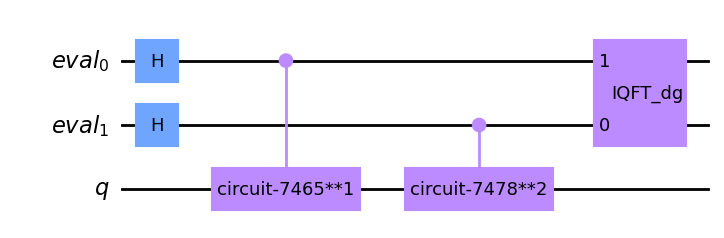

In [80]:
from qiskit.circuit.library import PhaseEstimation

resolution = 2
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

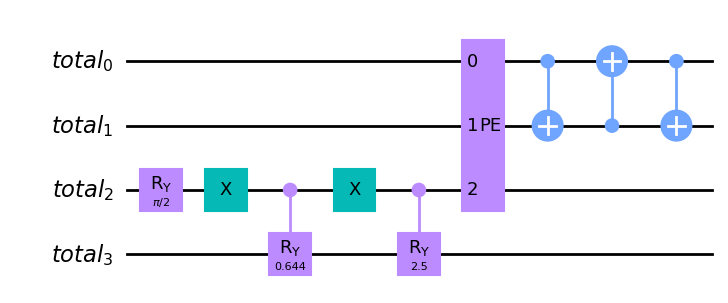

In [82]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[2:])
total_circuit.append(pe.to_gate(), qr_total[0:3])
# total_circuit.measure(qr_total[:2], classical[:])
total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()
#qstexp1 = StateTomography(total_circuit, measurement_qubits=[0,1])
#qstdata1 = qstexp1.run(backend, seed_simulation=100).block_for_results()

# Print results
#for result in qstdata1.analysis_results():
#    print(result)
total_circuit.decompose().draw("mpl")

In [84]:
# state_result = qstdata1.analysis_results("state")
# print(state_result.value)
# print('probabilities: ',np.diag(state_result.value)),len(np.diag(state_result.value))

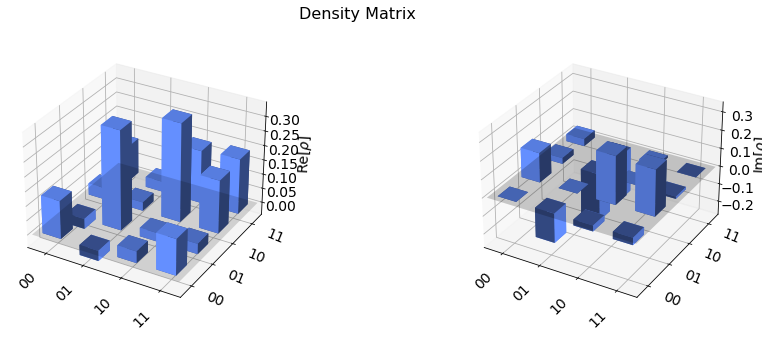

In [ ]:
plot_state_city(state_result.value.data, title='Density Matrix')

In [ ]:
diag = np.diag(state_result.value)
diag/np.sqrt(382/1641)

array([0.14356102+0.00000000e+00j, 0.96787526-2.14348325e-17j,
       0.73771767+1.60236893e-17j, 0.22348001-1.32963638e-35j])

In [86]:
from qiskit.visualization import plot_histogram

backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [87]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=6)))]

In [88]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [94]:
attach_bitstrings(statevector)

[('000000', (-0+0j)),
 ('000001', (0.2236-0j)),
 ('000010', (0.4472-0j)),
 ('000011', 0j),
 ('000100', (-0+0j)),
 ('000101', (-0.2236+0j)),
 ('000110', (0.4472-0j)),
 ('000111', 0j),
 ('001000', 0j),
 ('001001', (-0.2236+0j)),
 ('001010', (0.4472-0j)),
 ('001011', 0j),
 ('001100', (-0+0j)),
 ('001101', (0.2236-0j)),
 ('001110', (0.4472-0j)),
 ('001111', (-0+0j))]

In [89]:
#TODO:generalizzare il 2048/1641.
norm_factor_first_eigenvector = 1 / (0.4472**2*4) # 1 / somma dei quadrati degli stati associati all'autovettore
print(norm_factor_first_eigenvector)
np_sqrt = statevector * np.sqrt(norm_factor_first_eigenvector)
attach_bitstrings(np_sqrt)


1.250076004621081


[('000000', (-0+0j)),
 ('000001', (0.25+0j)),
 ('000010', (0.5+0j)),
 ('000011', 0j),
 ('000100', (-0+0j)),
 ('000101', (-0.25+0j)),
 ('000110', (0.5+0j)),
 ('000111', 0j),
 ('001000', 0j),
 ('001001', (-0.25+0j)),
 ('001010', (0.5+0j)),
 ('001011', 0j),
 ('001100', (-0+0j)),
 ('001101', (0.25+0j)),
 ('001110', (0.5+0j)),
 ('001111', (-0+0j))]

In [90]:
norm_factor_second_eigenvector = 1 / (0.2236**2*4)
attach_bitstrings(statevector*np.sqrt(norm_factor_second_eigenvector))

[('000000', (-0+0j)),
 ('000001', (0.5+0j)),
 ('000010', (1+0j)),
 ('000011', 0j),
 ('000100', (-0+0j)),
 ('000101', (-0.5+0j)),
 ('000110', (1+0j)),
 ('000111', 0j),
 ('001000', 0j),
 ('001001', (-0.5+0j)),
 ('001010', (1+0j)),
 ('001011', 0j),
 ('001100', (-0+0j)),
 ('001101', (0.5+0j)),
 ('001110', (1+0j)),
 ('001111', (-0+0j))]

In [91]:
np.sum(np.dot(statevector,statevector.T))

(0.9999392+0j)

In [95]:
# np.sqrt(382/2048), np.sqrt(410/2048),np.sqrt(412/2048),np.sqrt(437/2048)

In [93]:
np.linalg.eig(example_matrix)

(array([2., 1.]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))